In [4]:
import xarray as xr
import glob
import numpy as np
#import pandas as pd
import os
import glob
import copy as cp
import random
import pyproj as proj
import pickle 
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy as cr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from datetime import datetime

# Load trajs and visualize

In [5]:
files = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_new_*'))

In [53]:
ds = xr.open_dataset(files[0])
ds['southward'] = ds.lat.min(dim = 'obs')<65.5
ds['surface'] = ds.z.min(dim = 'obs')<0.5
ds

<xarray.Dataset>
Dimensions:      (traj: 25440, obs: 1459)
Dimensions without coordinates: traj, obs
Data variables: (12/18)
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float64 65.59 65.59 65.59 ... 66.04 66.04 66.04
    lon          (traj, obs) float64 ...
    z            (traj, obs) float64 0.494 0.494 0.494 ... 65.81 65.81 65.81
    uvel         (traj, obs) float64 ...
    ...           ...
    maskU        (traj, obs) float32 ...
    maskV        (traj, obs) float32 ...
    maskF        (traj, obs) float32 ...
    maskT        (traj, obs) float32 ...
    southward    (traj) bool False False False False ... False False False False
    surface      (traj) bool True False False False ... False False False False
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        0.1.dev2+g3bd3710
    parcels_mesh:           spherical

## Plot trajs random

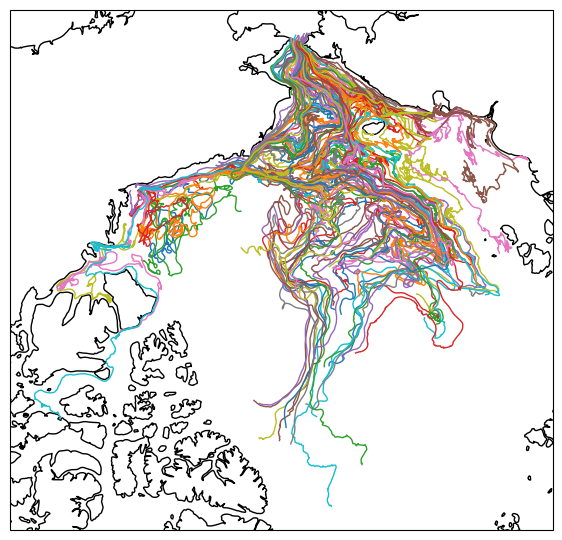

In [54]:
f = plt.figure(figsize = (7,7))
ax = f.add_subplot(1,1,1, projection = ccrs.NorthPolarStereo())
ax.coastlines()
for i in np.random.randint(0, ds.traj.shape[0], size = 100):
    ax.plot(ds.lon.isel(traj = i).values, ds.lat.isel(traj = i).values, transform = ccrs.PlateCarree(), lw = 1)

## Plot only shorts

In [64]:
print('Une partie des trajs courtes part au sud (Pacifique). \nProportion : ', np.round(ds.southward.where(ds.southward).count().values/ds.southward.count().values*100, 3), '% de toutes les trajs')
print('Une partie des trajs courtes fait surface et meure. \nProportion : ', np.round(ds.surface.where(ds.surface).count().values/ds.surface.count().values*100, 3), '% de toutes les trajs')
print('Aucune traj courte ne fait ni surface ni sud') 

Une partie des trajs courtes part au sud (Pacifique). 
Proportion :  4.595 % de toutes les trajs
Une partie des trajs courtes fait surface et meure. 
Proportion :  10.715 % de toutes les trajs
Aucune traj courte ne fait ni surface ni sud


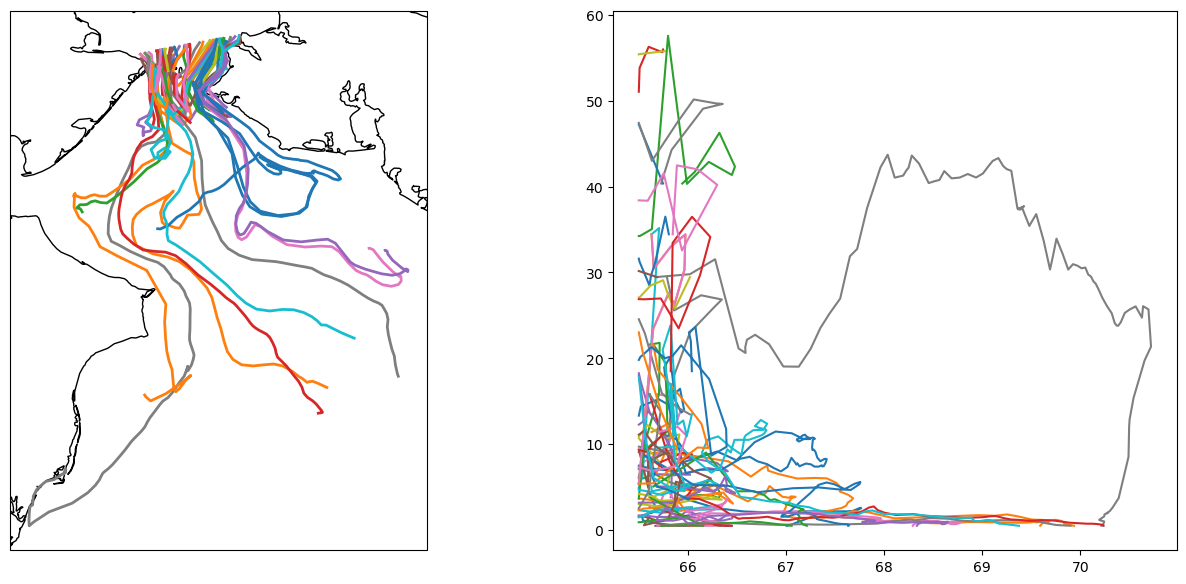

In [63]:
f = plt.figure(figsize = (16,7))
ax = f.add_subplot(1,2,1, projection = ccrs.NorthPolarStereo())
ax2 = f.add_subplot(1,2,2)
ax.coastlines()
for i in np.random.randint(0, ds.traj.shape[0], size = 1000):
    if len(ds.isel(traj=i).lat.dropna(dim='obs')) < 100 :#and ~ds.isel(traj=i).southward.values and ~ds.isel(traj = i).surface.values:
        #print(i, ds.lat.isel(traj = i).min().values)
        #print(ds.lon.isel(traj = i).dropna(dim='obs').values)
        #print(ds.lat.isel(traj = i).dropna(dim='obs').values)
        #print(ds.z.isel(traj = i).dropna(dim='obs').values)
        ax.plot(ds.lon.isel(traj = i).values, ds.lat.isel(traj = i).values, transform = ccrs.PlateCarree(), lw = 2, label = str(i))
        ax2.plot(ds.lat.isel(traj = i).values, ds.z.isel(traj = i).values)
#ax.legend()


## Est-ce normal de faire surface ? 

In [67]:
dsW = xr.open_dataset('/storage/nplanat/Glorys12_ORCA_journalier/Glorys12_GridW_1993_01_01.nc')
dsW

<xarray.Dataset>
Dimensions:       (depthw: 50, y: 580, x: 4322, time_counter: 1)
Coordinates:
  * depthw        (depthw) float32 0.0 1.011 2.086 ... 5.052e+03 5.5e+03
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
  * time_counter  (time_counter) datetime64[ns] 1993-01-01T12:00:00
  * x             (x) int32 1 2 3 4 5 6 7 ... 4316 4317 4318 4319 4320 4321 4322
  * y             (y) int32 2480 2481 2482 2483 2484 ... 3056 3057 3058 3059
Data variables:
    vovecrtz      (time_counter, depthw, y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    file_name:    GLORYS12V1_y2020m01d06_gridW.nc
    institution:  MERCATOR OCEAN
    source:       NEMO
    TimeStamp:    2020-NOV-30 18:39:43 GMT-0000
    references:   http://www.mercator-ocean.eu

In [75]:
1e2*dsW.vovecrtz.isel(time_counter = 0).isel(depthw = 0).max().values

0.0004589130639942596

/storage/nplanat/MINICONDA/envs/analysis/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


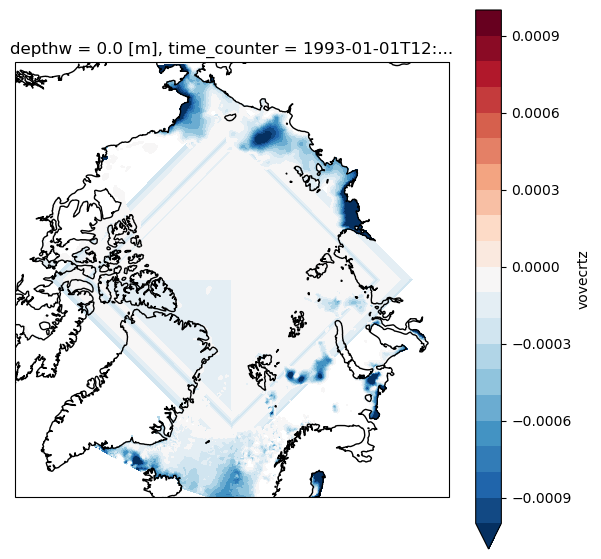

In [84]:
f = plt.figure(figsize = (7,7))
ax = f.add_subplot(1,1,1, projection = ccrs.NorthPolarStereo())
ax.coastlines()
(1e3*dsW.vovecrtz.isel(time_counter = 0).isel(depthw = 0)).where(dsW.vovecrtz.isel(time_counter = 0).isel(depthw = 0)<0, np.nan).plot.pcolormesh(levels = np.linspace(-0.001, 0.001, 21), ax = ax, x = 'nav_lon', y = 'nav_lat', transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, 65, 90],  crs=ccrs.PlateCarree())